# Trans Associations

In [2]:
import os
import re
import subprocess
import urllib2

import cdpybio as cpb
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None
import pybedtools as pbt
import seaborn as sns
import vcf as pyvcf

import cardipspy as cpy
import ciepy

%matplotlib inline

In [3]:
outdir = os.path.join(ciepy.root, 'output',
                      'trans_associations')
cpy.makedir(outdir)

private_outdir = os.path.join(ciepy.root, 'private_output',
                              'trans_associations')
cpy.makedir(private_outdir)

In [4]:
fn = ('/projects/CARDIPS/pipeline/Hi-C/alignment/merged_TAD/'
      'iPSC.OB.KR.5000.200kbWindow.hmm_7col.tad')
tads = pbt.BedTool(fn)

In [5]:
fn = os.path.join(os.path.split(cpy.roadmap_15_state_annotation)[0], 'EIDlegend.txt')
roadmap_ids = pd.read_table(fn, squeeze=True, index_col=0, header=None)

fn = os.path.join(ciepy.root, 'output', 'functional_annotation_analysis',
                  'encode_stem_cell_chip_seq.tsv')
encode_chip_seq = pd.read_table(fn, index_col=0)

gene_info = pd.read_table(cpy.gencode_gene_info, index_col=0)
t_to_g = pd.read_table(cpy.gencode_transcript_gene, index_col=0, header=None, 
                       squeeze=True)

fn = 'ftp://ftp.informatics.jax.org/pub/reports/HOM_AllOrganism.rpt'
conv = pd.read_table(fn, index_col=0, low_memory=False)
mouse_genes = conv[conv['Common Organism Name'] == 'mouse, laboratory']
human_genes = conv[conv['Common Organism Name'] == 'human']

# Supplementary table from http://www.nature.com/nature/journal/v501/n7466/full/nature12420.html.
fn = 'http://www.nature.com/nature/journal/v501/n7466/extref/nature12420-s3.xls'
wit_nanog = pd.read_excel(fn)

fn = os.path.join(ciepy.root, 'output', 'eqtl_input', 
                  'tpm_log_filtered_phe_std_norm_peer_resid.tsv')
exp = pd.read_table(fn, index_col=0)

vcf_fn = os.path.join(ciepy.root, 'private_output/eqtl_input/filtered_all/0000.vcf.gz')
vcf_reader = pyvcf.Reader(open(vcf_fn), compressed=True)

In [6]:
mouse_genes['symbol_upper'] = mouse_genes['Symbol'].apply(lambda x: x.upper())
mouse_genes.ix[mouse_genes.Synonyms.isnull() == False, 'synonyms_list'] = \
    mouse_genes.ix[mouse_genes.Synonyms.isnull() == False, 
                   'Synonyms'].apply(lambda x: [y.upper() for y in x.split('|')])
syns = set([item for sublist in mouse_genes.synonyms_list.dropna().values for item in sublist])
synonyms_list = mouse_genes.ix[mouse_genes.synonyms_list.isnull() == False, 'synonyms_list']

## *NANOG Trans* Associations

In [5]:
wit_bt = pbt.BedTool('\n'.join(wit_nanog.chromosome + '\t' + 
                               wit_nanog.start.astype(str) + 
                               '\t' + wit_nanog.end.astype(str)) + '\n',
                     from_string=True)

In [6]:
wit_nanog['human_gene_name'] = np.nan
wit_nanog['HomoloGene ID'] = np.nan
for i in wit_nanog.index:
    g = wit_nanog.ix[i, 'associated gene'].upper()
    t = mouse_genes[mouse_genes.symbol_upper == g]
    if t.shape[0] == 0:
        if g in syns:
            t = synonyms_list[synonyms_list.apply(lambda x: g in x)]
    if t.shape[0] == 1:
        if t.index[0] in human_genes.index.values:
            wit_nanog.ix[i, 'HomoloGene ID'] = t.index[0]
            ht = human_genes.ix[t.index[0], 'Symbol']
            if type(ht) == str:
                wit_nanog.ix[i, 'human_gene_name'] = ht
            else:
                wit_nanog.ix[i, 'human_gene_name'] = '|'.join(ht.values)

In [7]:
wit_nanog['human_gene_id'] = np.nan
for i in wit_nanog.human_gene_name.dropna().index:
    t = gene_info[gene_info.gene_name == wit_nanog.ix[i, 'human_gene_name']]
    if t.shape[0] == 1:
        wit_nanog.ix[i, 'human_gene_id'] = t.index[0]
    elif t.shape[0] == 0:
        t = gene_info[gene_info.gene_name.apply(lambda x: x.upper()) == 
                      wit_nanog.ix[i, 'human_gene_name'].upper()]

In [8]:
# I can go to 100000. Most local QTLs are closer than that.
tss = pbt.BedTool(cpy.gencode_tss_bed)
tss_2kb = tss.slop(l=2000, r=2000, g=pbt.genome_registry.hg19).merge()
tss_intersect = tss_2kb.intersect(tss, wo=True, sorted=True)

genes_to_tss = {}
for r in tss_intersect:
    g = t_to_g[r.fields[6].split('_')[0]]
    genes_to_tss[g] = genes_to_tss.get(g, set()) | set(['{}:{}-{}'.format(r.chrom, r.start, r.end)])
genes_to_tss = pd.Series(genes_to_tss)

In [9]:
regions = reduce(lambda x,y: x | y, genes_to_tss[wit_nanog.human_gene_id.dropna()])
starts = np.array([int(y.split(':')[1]) for y in [x.split('-')[0] for x in regions]])
ends = np.array([int(x.split('-')[1]) for x in regions])
print('Going to test {} regions from {} genes encompassing {:,} bp.'.format(
        len(regions), len(set(wit_nanog.human_gene_id.dropna())), (ends - starts).sum()))

Going to test 681 regions from 264 genes encompassing 3,762,272 bp.


In [10]:
gene_id = gene_info[gene_info.gene_name == 'NANOG'].index[0]
toutdir = os.path.join(outdir, 'wit_nanog_trans')

if not os.path.exists(toutdir):
    cpy.makedir(toutdir)
    fn = os.path.join(toutdir, 'wit_nanog_trans.sh')
    regions = ','.join(reduce(lambda x,y: x | y, genes_to_tss[wit_nanog.human_gene_id.dropna()]))
    regions = regions.replace('chr', '')
    with open(fn, 'w') as f:
        c = '#!/bin/bash\n\nmodule load cardips\nsource activate cie\n\n'
        c += 'python {} \\\n\t'.format(os.path.join(ciepy.root, 'scripts', 'run_emmax.py'))
        c += ' \\\n\t'.join([
                gene_id,
                vcf_fn,
                regions,
                os.path.join(ciepy.root, 'output', 'eqtl_input', 
                             'tpm_log_filtered_phe_std_norm_peer_resid.tsv'),
                os.path.join(ciepy.root, 'output', 'eqtl_input', 'emmax_samples.tsv'),
                os.path.join(ciepy.root, 'output', 'eqtl_input', 'wgs.kin'),
                toutdir,
                '-c {}'.format(os.path.join(ciepy.root, 'output', 'eqtl_input', 
                                            'emmax_sex_only.tsv')),
                '-i 10000 -a 20000'
            ])
        f.write(c + '\n')
    subprocess.check_call('bash {}'.format(fn), shell=True)

In [11]:
res = ciepy.read_emmax_output(os.path.join(toutdir, '{}.tsv'.format(gene_id)))
res = res.sort_values(by='PVALUE')
min_pvals = pd.read_table(os.path.join(toutdir, 'minimum_pvalues.tsv'),                            
                          header=None, squeeze=True)
p = (1 + sum(min_pvals <= res.PVALUE.min())) / float(min_pvals.shape[0] + 1)

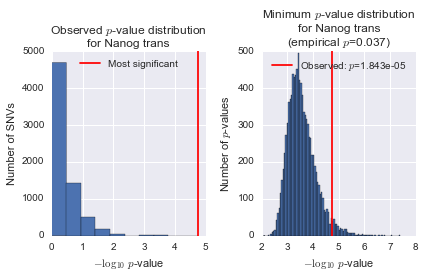

In [13]:
fig, axs = plt.subplots(1, 2)
ax = axs[0]
(-np.log10(res.PVALUE)).hist(ax=ax)
ya, yb = ax.get_ylim()
ax.vlines(-np.log10(res.PVALUE.min()), ya, yb,
          color='red', label='Most significant')
ax.legend(loc='upper center')
ax.set_title('Observed $p$-value distribution\nfor Nanog trans')
ax.set_xlabel('$-\log_{10}$ $p$-value')
ax.set_ylabel('Number of SNVs')

ax = axs[1]
ax = (-np.log10(min_pvals)).hist(bins=100, ax=ax)
ax.set_ylabel('Number of $p$-values')
ax.set_xlabel('$-\log_{10}$ $p$-value')
ya, yb = ax.get_ylim()
ax.vlines(-np.log10(res.PVALUE.min()), ya, yb, colors=['red'], 
          label='Observed: $p$={}'.format(res.PVALUE.min()))
ax.legend()
ax.set_title('Minimum $p$-value distribution\nfor Nanog trans\n(empirical $p$={:.3f})'.format(p))
plt.tight_layout();

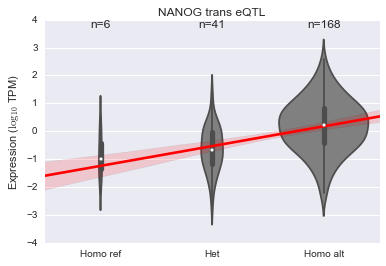

In [14]:
t =  vcf_reader.fetch('{}'.format(res.CHROM.values[0]), 
                      res.BEG.values[0], res.BEG.values[0] + 1)
r = t.next()
tdf = pd.DataFrame(exp.ix[gene_id])
tdf.columns = ['expression']
tdf['genotype'] = 0
hets = set(exp.columns) & set([s.sample for s in r.get_hets()])
tdf.ix[hets, 'genotype'] = 1
alts = set(exp.columns) & set([s.sample for s in r.get_hom_alts()])
tdf.ix[alts, 'genotype'] = 2
plt.figure()
ax = sns.violinplot(x='genotype', y='expression', data=tdf, color='grey',
                order=[0, 1, 2], scale='count')
ax = sns.regplot(x='genotype', y='expression', data=tdf, scatter=False, color='red')
ax.set_xticklabels(['Homo ref', 'Het', 'Homo alt'])
ax.set_ylabel('Expression ($\log_{10}$ TPM)')
ax.set_xlabel('')
ya, yb = plt.ylim()
plt.text(0, yb, 'n={}'.format(sum(tdf.genotype == 0)), 
         verticalalignment='top', horizontalalignment='center', fontsize=12)
plt.text(1, yb, 'n={}'.format(sum(tdf.genotype == 1)), 
         verticalalignment='top', horizontalalignment='center', fontsize=12)
plt.text(2, yb, 'n={}'.format(sum(tdf.genotype == 2)), 
         verticalalignment='top', horizontalalignment='center', fontsize=12)
plt.title('{} trans eQTL'.format(gene_info.ix[gene_id, 'gene_name']));
plt.savefig(os.path.join(outdir, 'nanog_trans_eqtl.pdf'));

This appears to be a *trans* eQTL for *NANOG*. The variant lies in a
weak enhancer region in H1-hESCs (chr16:90,102,249-90,102,518) that 
is mainly marked by H3K4me1 and is in the intron of the *GAS8* gene.

In [15]:
res[res.PVALUE == res.PVALUE.min()]

,CHROM,BEG,END,MARKER_ID,NS,AC,CALLRATE,GENOCNT,MAF,STAT,PVALUE,BETA,SEBETA,R2
854,16,90102384,90102384,16:90102384_C/A_rs4785766,215,377,1,6/41/168,0.12326,4.3828,0.000018,0.6202,0.1415,0.08308


In [16]:
sig_bt = pbt.BedTool('chr{}\t{}\t{}\n'.format(res.CHROM[0], res.BEG[0] - 1, res.END[0]), 
                     from_string=True)
overlap = pd.Series(False, index=encode_chip_seq.target)
for i in encode_chip_seq.index:
    c = encode_chip_seq.ix[i, 'target']
    bt = pbt.BedTool(cpb.general.read_gzipped_text_url(encode_chip_seq.ix[i, 'narrowPeak_url']), 
                     from_string=True)
    bt = bt.sort()
    inter = sig_bt.intersect(bt, sorted=True, wo=True)
    if len(inter) > 0:
        overlap[c] = True

In [17]:
url = ('http://egg2.wustl.edu/roadmap/data/byFileType'
       '/peaks/consolidated/narrowPeak/')
website = urllib2.urlopen(url)
html = website.read()
files = re.findall('href="(E\d\d\d-DNase.macs2.narrowPeak.gz)"', html)
roadmap_dnase_res = pd.DataFrame(
    -1, index=[x.split('-')[0] for x in files], 
    columns=['odds_ratio', 'pvalue'])

urls = ['http://egg2.wustl.edu/roadmap/data/byFileType/peaks/consolidated/narrowPeak/{}'.format(n)
        for n in files]
lines = ['iPS-15b Cell Line', 'iPS-18 Cell Line', 'iPS-20b Cell Line',
         'iPS DF 6.9 Cell Line', 'iPS DF 19.11 Cell Line', 'H1 Cell Line',
         'H9 Cell Line']
urls = [x for x in urls if roadmap_ids[os.path.split(x.split('-')[0])[1]] in lines]

r = []
for url in urls:
    line = roadmap_ids[os.path.split(url)[1].split('-')[0]]
    bt = pbt.BedTool(cpb.general.read_gzipped_text_url(url), from_string=True).sort()
    r.append(sig_bt.intersect(bt, sorted=True, wo=True))

In [18]:
sum([len(x) > 0 for x in r])

0

### Nearby SNVs

I'd like to look at other SNVs near this one that appears to have a significant
trans association to see whether any others are more strongly associated. 

In [16]:
gene_id = gene_info[gene_info.gene_name == 'NANOG'].index[0]
toutdir = os.path.join(outdir, 'nanog_gas8')

if not os.path.exists(toutdir):
    t = tss.slop(l=1000000, r=1000000, g=pbt.genome_registry.hg19).merge()
    res = t.intersect(tss, wo=True, sorted=True)
    t = {}
    for r in res:
        g = t_to_g[r.fields[6].split('_')[0]]
        t[g] = t.get(g, set()) | set(['{}:{}-{}'.format(r.chrom, r.start, r.end)])
    t = pd.Series(t)
    regions = ','.join(t[gene_info[gene_info.gene_name == 'GAS8'].index[0]]).replace('chr', '')
    
    cpy.makedir(toutdir)
    fn = os.path.join(toutdir, 'nanog_gas8.sh')
    with open(fn, 'w') as f:
        c = '#!/bin/bash\n\nmodule load cardips\nsource activate cie\n\n'
        c += 'python {} \\\n\t'.format(os.path.join(ciepy.root, 'scripts', 'run_emmax.py'))
        c += ' \\\n\t'.join([
                gene_id,
                vcf_fn,
                regions,
                os.path.join(ciepy.root, 'output', 'eqtl_input', 
                             'tpm_log_filtered_phe_std_norm_peer_resid.tsv'),
                os.path.join(ciepy.root, 'output', 'eqtl_input', 'emmax_samples.tsv'),
                os.path.join(ciepy.root, 'output', 'eqtl_input', 'wgs.kin'),
                toutdir,
                '-c {}'.format(os.path.join(ciepy.root, 'output', 'eqtl_input', 
                                            'emmax_sex_only.tsv')),
            ])
        f.write(c + '\n')
    subprocess.check_call('bash {}'.format(fn), shell=True)

In [17]:
gas8_res = ciepy.read_emmax_output(os.path.join(toutdir, '{}.tsv'.format(gene_id)))
gas8_res = gas8_res.sort_values(by=['PVALUE'])
gas8_min_pvals = pd.read_table(os.path.join(toutdir, 'minimum_pvalues.tsv'),                            
                               header=None, squeeze=True)
gas8_p = (1 + sum(gas8_min_pvals <= gas8_res.PVALUE.min())) / float(gas8_min_pvals.shape[0] + 1)

In [18]:
gas8_res = ciepy.read_emmax_output(os.path.join(toutdir, '{}.tsv'.format(gene_id)))
gas8_res = gas8_res.sort_values(by=['PVALUE'])

/frazer01/home/cdeboever/software/anaconda/envs/cie/lib/python2.7/site-packages/ipykernel/__main__.py:2: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  from ipykernel import kernelapp as app


In [19]:
res.index = ('chr' + res.CHROM.astype(str) + ':' + 
             res.BEG.astype(str) + '-' + res.END.astype(str))
gas8_res.index = ('chr' + gas8_res.CHROM.astype(str) + ':' + 
                  gas8_res.BEG.astype(str) + '-' + gas8_res.END.astype(str))

In [20]:
shared = set(res.index) & set(gas8_res.index)
not_shared = set(gas8_res.index) - shared

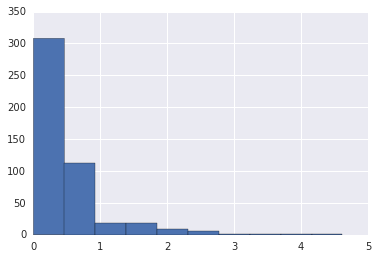

In [21]:
(-np.log10(gas8_res.ix[shared, 'PVALUE'])).hist()

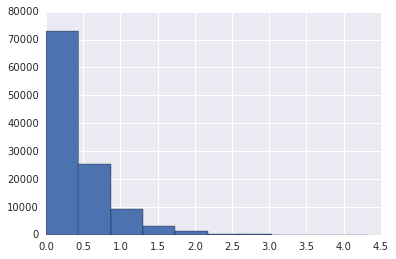

In [22]:
(-np.log10(gas8_res.ix[not_shared, 'PVALUE'])).hist()

In [ ]:
2 + 

## TADs

In [7]:
df = tads.to_dataframe()

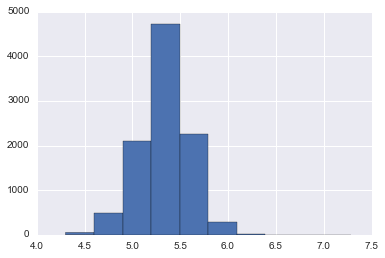

In [10]:
np.log10((df.end - df.start)).hist()

In [7]:
2  +3

5